In [1]:
import gymnasium
import skyscraper
import numpy as np
from collections import defaultdict 

import random
import time
np.random.seed(0)
random.seed(0)

env = gymnasium.make('skyscraper/GridWorld-v0')

In [2]:
env.reset()

({'agent': {'pos': array([13,  5])}}, {'distance': 49, 'steps': 0})

In [3]:
env.step(1)

c:\Users\saraa\anaconda3\envs\inf368\Lib\site-packages\gymnasium\utils\passive_env_checker.py:135: UserWarning: WARN: The obs returned by the `step()` method was expecting numpy array dtype to be int32, actual type: float64
  logger.warn(
c:\Users\saraa\anaconda3\envs\inf368\Lib\site-packages\gymnasium\utils\passive_env_checker.py:159: UserWarning: WARN: The obs returned by the `step()` method is not within the observation space.
  logger.warn(f"{pre} is not within the observation space.")


({'agent': {'pos': array([14.,  8.])}},
 0,
 False,
 False,
 {'distance': 46.0, 'steps': 1})

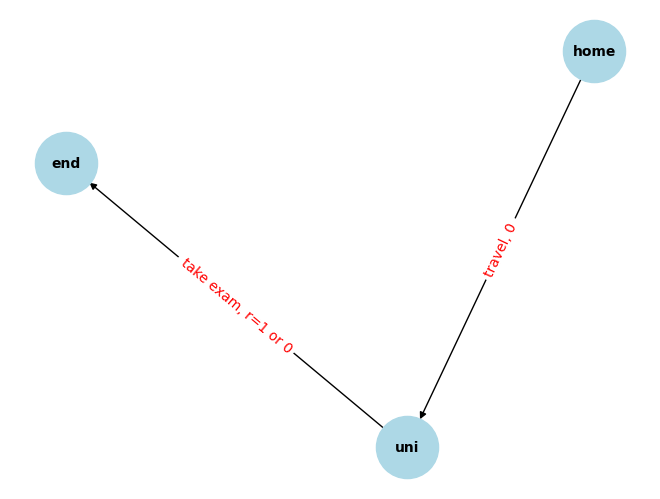

In [4]:
import networkx as nx
import matplotlib.pyplot as plt

# Create a new directed graph
G = nx.DiGraph()

# Define the states and actions with rewards
states = ["home", "uni", "end"]
actions = {
    "home": [("uni", "travel", 0)],
    "uni": [("end", "take exam", "r=1 or 0")]
}

# Add nodes and edges with labels for each state and action
for state in states:
    G.add_node(state)

for source_state, action_list in actions.items():
    for target_state, action, reward in action_list:
        G.add_edge(source_state, target_state, label=f"{action}, {reward}")

# Position nodes using the spring layout
pos = nx.spring_layout(G)

# Draw the graph
nx.draw(G, pos, with_labels=True, node_size=2000, node_color="lightblue", font_size=10, font_weight="bold")

# Draw edge labels
edge_labels = nx.get_edge_attributes(G, 'label')
nx.draw_networkx_edge_labels(G, pos, edge_labels=edge_labels, font_color='red')

plt.show()


## Env dynamics

In [5]:
# powered_flight_data = open('powered_flight.txt', 'r')
# powered_flight_data = powered_flight_data.read().split('\n')
# len(powered_flight_data)
# powered_flight_data


### First need to fix index problem, right know they are 1-indexed need to become 0-indexed bc env is 0-indexed.

In [6]:
# def fix_index(powered_flight_data):
#     fixed_data = []
#     for line in powered_flight_data:
#         data = line.strip().split('\t')
#         print(data)
#         if not data or len(data) != 6:
#              continue
        
#         try:
#             print("here")
#             adjusted_data = [int(value) - 1 if value else None for value in data]
#             # print("adjusted1: ",adjusted_data)
#             adjusted_data = [value for value in adjusted_data if value is not None]
#             # print("adjusted2: ",adjusted_data)
#             fixed_data.append(adjusted_data)
#         except ValueError as e:
#             print(f"Error processing line: {line} - {e}")
#     return fixed_data
# fixed_powered_flight_data = fix_index(powered_flight_data)
# fixed_powered_flight_data


In [7]:
# print(len(fixed_powered_flight_data))
# print(len(powered_flight_data))


In [8]:
a={1:1,2:3,4:5}

3 in a.values()

True

In [9]:
data = np.loadtxt('powered_flight.txt', dtype=int)
data[:,:3] -= 1
data[:,4:6] -= 1



### Transtition function, reward function and model M:

In [10]:
transition_function = {}  # Transition function: (state, action) -> next state

for i, j, a, r, i_prime, j_prime in data:
    
    current_state = (i, j)
    next_state = (i_prime, j_prime)
    action = a
    
    transition_function[(current_state, action)] = next_state
transition_function_original = transition_function.copy()
transition_function

{((17, 16), 0): (16, 12),
 ((3, 60), 0): (3, 56),
 ((11, 19), 1): (10, 22),
 ((16, 9), 1): (18, 11),
 ((7, 14), 0): (8, 11),
 ((2, 37), 0): (2, 34),
 ((17, 16), 1): (16, 20),
 ((4, 55), 0): (4, 51),
 ((3, 39), 1): (1, 42),
 ((2, 58), 1): (2, 63),
 ((2, 56), 1): (3, 60),
 ((1, 53), 0): (2, 51),
 ((9, 13), 1): (10, 16),
 ((18, 57), 1): (20, 60),
 ((1, 55), 0): (1, 52),
 ((7, 10), 1): (7, 14),
 ((3, 53), 1): (2, 56),
 ((10, 17), 0): (11, 14),
 ((5, 54), 0): (4, 51),
 ((5, 48), 0): (3, 44),
 ((3, 60), 1): (4, 63),
 ((2, 60), 0): (2, 57),
 ((6, 63), 1): (8, 55),
 ((9, 24), 0): (8, 21),
 ((0, 54), 1): (1, 58),
 ((3, 56), 1): (3, 60),
 ((1, 47), 1): (1, 52),
 ((6, 13), 1): (6, 17),
 ((3, 19), 1): (2, 22),
 ((11, 59), 1): (14, 62),
 ((8, 25), 0): (7, 22),
 ((13, 20), 1): (11, 22),
 ((21, 13), 0): (22, 11),
 ((3, 42), 1): (2, 45),
 ((4, 6), 1): (5, 9),
 ((1, 27), 1): (3, 31),
 ((1, 42), 0): (2, 40),
 ((1, 53), 1): (2, 57),
 ((7, 54), 1): (5, 58),
 ((10, 17), 1): (11, 20),
 ((15, 17), 1): (14, 2

In [11]:
reward_function = {}  # Reward function: (state, action, next state) -> reward

for i, j, a, r, i_prime, j_prime in data:
    current_state = (i, j)
    next_state = (i_prime, j_prime)
    action = a
    
    reward_function[(current_state, action)] = r
    
reward_function_original = reward_function.copy()
reward_function


{((17, 16), 0): 0,
 ((3, 60), 0): 0,
 ((11, 19), 1): 0,
 ((16, 9), 1): 0,
 ((7, 14), 0): 0,
 ((2, 37), 0): 0,
 ((17, 16), 1): 0,
 ((4, 55), 0): 0,
 ((3, 39), 1): 0,
 ((2, 58), 1): 0,
 ((2, 56), 1): 0,
 ((1, 53), 0): 0,
 ((9, 13), 1): 0,
 ((18, 57), 1): 0,
 ((1, 55), 0): 0,
 ((7, 10), 1): 0,
 ((3, 53), 1): 0,
 ((10, 17), 0): 0,
 ((5, 54), 0): 0,
 ((5, 48), 0): 0,
 ((3, 60), 1): 0,
 ((2, 60), 0): 0,
 ((6, 63), 1): 0,
 ((9, 24), 0): 0,
 ((0, 54), 1): 0,
 ((3, 56), 1): 0,
 ((1, 47), 1): 0,
 ((6, 13), 1): 0,
 ((3, 19), 1): 0,
 ((11, 59), 1): 0,
 ((8, 25), 0): 0,
 ((13, 20), 1): 0,
 ((21, 13), 0): 0,
 ((3, 42), 1): 0,
 ((4, 6), 1): 0,
 ((1, 27), 1): 0,
 ((1, 42), 0): 0,
 ((1, 53), 1): 0,
 ((7, 54), 1): 0,
 ((10, 17), 1): 0,
 ((15, 17), 1): 0,
 ((13, 58), 1): 0,
 ((12, 9), 1): 0,
 ((13, 5), 1): 0,
 ((5, 55), 1): 0,
 ((6, 57), 1): 0,
 ((16, 12), 1): 0,
 ((4, 25), 1): 0,
 ((1, 13), 1): 0,
 ((3, 22), 1): 0,
 ((5, 62), 0): 0,
 ((9, 18), 1): 0,
 ((11, 10), 0): 0,
 ((0, 61), 0): 0,
 ((24, 11), 0): 

In [12]:
def model_M(current_state, action, transition_function, reward_function):
   
    next_state = transition_function.get((current_state, action), None)  # Get the next state from T
    # print("next_state: ",next_state)
    reward = reward_function.get((current_state, action), 0)  # Get the reward from R
    # print("reward: ",reward)
    
    return next_state, reward
print(model_M((12, 17), 0, transition_function, reward_function))


((12, 13), 0)


## Dyna arcitecture:

In [13]:
action_space = [0, 1]  
alpha = 0.5
gamma = 0.99
epsilon = 0.3
n_planning_steps = 1000
# punishment=0.1
T = 5000  # Total number of real interactions
state = env.reset()[0]['agent']['pos']
state = tuple(state)


# Initialize Q-values
# Q = defaultdict(lambda: np.zeros(env.action_space.n))
Q=np.zeros((env.height,env.width,env.action_space.n))




c:\Users\saraa\anaconda3\envs\inf368\Lib\site-packages\gymnasium\core.py:311: UserWarning: WARN: env.height to get variables from other wrappers is deprecated and will be removed in v1.0, to get this variable you can do `env.unwrapped.height` for environment variables or `env.get_wrapper_attr('height')` that will search the reminding wrappers.
  logger.warn(
c:\Users\saraa\anaconda3\envs\inf368\Lib\site-packages\gymnasium\core.py:311: UserWarning: WARN: env.width to get variables from other wrappers is deprecated and will be removed in v1.0, to get this variable you can do `env.unwrapped.width` for environment variables or `env.get_wrapper_attr('width')` that will search the reminding wrappers.
  logger.warn(


In [14]:
# Choose action based on ε-greedy policy
def choose_action(state, Q, epsilon):
    if random.random() < epsilon:
        # print("random")
        return env.action_space.sample()  
    else:
        
        return np.argmax(Q[state])  

# Direct learning from real experience
# def q_learning_update(Q, state, action, reward, next_state, alpha, gamma):
    
#     best_next_action = np.argmax(Q[next_state])
    
#     td_target = reward + gamma * Q[next_state][best_next_action]
#     td_error = td_target - Q[state][action]
#     Q[state][action] += alpha * td_error
    
# def q_learning(Q, env, alpha, gamma, epsilon, num_episodes):
#     for episode in range(num_episodes):
#         state = env.reset()[0]['agent']['pos']
#         state = tuple(state)
#         done = False
        
#         while not done:
#             action = choose_action(state, Q, epsilon)
#             next_state, reward, done, _, _ = env.step(action)
#             next_state = tuple(map(int, next_state['agent']['pos']))
            
#             q_learning_update(Q, state, action, reward, next_state, alpha, gamma)
            
#             state = next_state
    
#     return Q

def q_learning(state, action, reward, next_state, value, discound,lr):

    # value of previous state-action pair
    i,j = state
    prev_value = value[i,j,action]

    # maximum Q-value at current state
    if next_state is None or np.isnan(next_state).any():
        max_value = 0
    else:
        n_i,n_j = next_state
        max_value = np.max(value[n_i,n_j, :])

    # reward prediction error
    delta = reward + discound * max_value - prev_value

    # update value of previous state-action pair
    value[i,j,action] = prev_value + lr * delta

    return value
    


In [15]:
def print_optimal_policy(Q):
   return np.argmax(Q,axis=2)
        # print(f"Optimal action for state {state} is {optimal_action}")

print_optimal_policy(Q)


# Main loop for Dyna-Q

for k in range(T):
    # epsilon = epsilon * 0.99
    # print(k)
    if k % 100 == 0:
        print(f"Real interaction {k}/{T}")
    
    state =env.reset()[0]['agent']['pos']
    state = tuple(state)
    start_state=state
    # print("start state", start_state)
    # print("state: ",state)  
    done = False
    
    done = False
    while not done:
        
        
        action = choose_action(state, Q, epsilon)
        
        next_state, reward, done, err, info = env.step(action) 
        
        next_state = tuple(map(int,next_state['agent']['pos']))
        #print("next state", next_state)
        
        q_learning(state, action, reward, next_state, Q, gamma, alpha)
        transition_function[(state, action)] = next_state
        reward_function[(state, action)] = reward
        
        crashed  = (start_state==next_state and state != start_state)
        
        state = next_state
        #print("state", state)
        
        if done or crashed:
            done = True
        # print("state", state)
    
    
    
# print('after')
    for m in range(n_planning_steps):
        # print("m: ",m)
        sampled_state, sampled_action = random.choice(list(transition_function.keys()))
        #sampled_action = random.choice(action_space)
        if (sampled_state, sampled_action) in transition_function:
            # simulated_next_state, simulated_reward = model_M(sampled_state, sampled_action, transition_function, reward_function)
            simulated_next_state = transition_function[(sampled_state, sampled_action)]
            simulated_reward = reward_function[(sampled_state, sampled_action)]
            q_learning(sampled_state, sampled_action, simulated_reward, simulated_next_state,Q, gamma,alpha)
            # print('hi')

# env.close()
policy=print_optimal_policy(Q)



Real interaction 0/1000
Real interaction 100/1000
Real interaction 200/1000
Real interaction 300/1000
Real interaction 400/1000
Real interaction 500/1000


KeyboardInterrupt: 

In [ ]:
reward_function==reward_function_original

In [ ]:
# Assuming other parts of your code remain unchanged
def run_with_policy(env, policy_matrix, num_steps=1000):
    observation, _ = env.reset()
    # Convert observation to initial position tuple
    current_pos = tuple(map(int, observation["agent"]["pos"]))

    for step in range(num_steps):
        if step % 10 == 0:
            print(f"Steps: {step} to {step + 99} of {num_steps}")

        # env.render()

        # Directly use current_pos to get the best action from the policy matrix
        action = policy_matrix[current_pos]
        print("action: ",action)
        #print(f"Action: {action}")

        # Take the action in the environment
        observation, reward, done, _, _ = env.step(action)

        # Update current position based on the observation
        current_pos = tuple(map(int, observation["agent"]["pos"]))
        
        print(f"Current Position: {current_pos}")

        if done:
            #print("Reached the goal or crashed, resetting.")
            observation, _ = env.reset()
            current_pos = tuple(map(int, observation["agent"]["pos"]))

    # env.close()

#env = gymnasium.make('skyscraper/GridWorld-v0',render_mode="human")
#print("Run with policy")
#run_with_policy(env, policy)
# env.close()

In [ ]:
import matplotlib.pyplot as plt
env.reset()
env_map = env.MAP  # Make sure this is the correct way to access the map

# Visualize the environment
plt.imshow(env_map, cmap='copper', interpolation='nearest')
plt.colorbar()
plt.show()


In [ ]:
policy

In [ ]:
def follow_policy(env, policy):
    total_reward = 0
    trajectory = []
    done = False
    state= env.reset()[0]['agent']['pos']
    state = tuple([int(state[0]),int(state[1])])
    trajectory.append(state)
    
    while not done:
        print("state: ",state)
        action = policy[state[0], state[1]]  # Adjust based on your state definition
        next_state, reward, done, _, _ = env.step(action)
        next_state = next_state['agent']['pos']  # Corrected line
        total_reward += reward
        state = tuple([int(next_state[0]),int(next_state[1])])
        trajectory.append(state)
        
        if done:
            break  # Exit the loop if the episode is done
    
    return total_reward, trajectory

# Convert Q-values to policy
# policy = np.argmax(Q, axis=2)  # Make sure this aligns with how your Q-table is structured

# # Follow the policy
# control_total_reward, control_trajectory = follow_policy(env, policy)
# print("Total Reward:", control_total_reward)
# print("Trajectory:", control_trajectory)

# plt.imshow(env_map, cmap='copper', interpolation='nearest')  # Use 'viridis' or another colormap as needed
# plt.plot([x[1] for x in control_trajectory], [x[0] for x in control_trajectory], color='purple', markersize=5, linewidth=2)

# # Show the plot
# plt.show()


# task 4

In [ ]:
# policy1 =runq(env,0)



In [ ]:
total_reward, trajectory = follow_policy(env, policy)


In [ ]:
plt.imshow(env_map, cmap='viridis', interpolation='nearest')  # Use 'viridis' or another colormap as needed
plt.colorbar()
plt.plot([x[1] for x in trajectory], [x[0] for x in trajectory], color='black', markersize=5, linewidth=2)

# Show the plot
plt.show()

In [ ]:
# # Other parts of your original code omitted for brevity
# # ...action_space = [0, 1]  
# # alpha = 0.5
# # gamma = 0.99
# # epsilon = 0.3
# # #n_planning_steps = 1000
# # # punishment=0.1
# # T = 1000  # Total number of real interactions
# # state = env.reset()[0]['agent']['pos']
# # state = tuple(state)


# # Initialize Q-values
# # Q = defaultdict(lambda: np.zeros(env.action_space.n))
# Q=np.zeros((env.height,env.width,env.action_space.n))


# def print_optimal_policy(Q):
#    return np.argmax(Q,axis=2)
#         # print(f"Optimal action for state {state} is {optimal_action}")

# print_optimal_policy(Q)

# def run_dyna_Q(env,n_planning_steps):
#     env.reset()
    
#     Q = np.zeros((env.height, env.width, env.action_space.n))
#     # Initialize your Q-table each time to start learning from scratch

#     # Copy the Dyna-Q learning loop here
#     for k in range(T):
#     # epsilon = epsilon * 0.99
#         print(k)
#         if k % 100 == 0:
#             print(f"Real interaction {k}/{T}")
        
#         state =env.reset()[0]['agent']['pos']
#         state = tuple(state)
#         start_state=state
    
#         done = False
        
#         done = False
#         while not done:
            
            
#             action = choose_action(state, Q, epsilon)
            
#             next_state, reward, done, err, info = env.step(action) 
            
#             next_state = tuple(map(int,next_state['agent']['pos']))
#             #print("next state", next_state)
            
#             q_learning(state, action, reward, next_state, Q, gamma, alpha)
#             transition_function[(state, action)] = next_state
#             reward_function[(state, action)] = reward
            
#             crashed  = (start_state==next_state and state != start_state)
            
#             state = next_state
#             #print("state", state)
            
#             if done or crashed:
#                 done = True
#         # print("state", state)
        
        
        
#         # print('after')
#         for m in range(n_planning_steps):
#             print("m: ",m)
#             sampled_state, sampled_action = random.choice(list(transition_function.keys()))
#             #sampled_action = random.choice(action_space)
#             if (sampled_state, sampled_action) in transition_function:
#                 # simulated_next_state, simulated_reward = model_M(sampled_state, sampled_action, transition_function, reward_function)
#                 simulated_next_state = transition_function[(sampled_state, sampled_action)]
#                 simulated_reward = reward_function[(sampled_state, sampled_action)]
#                 q_learning(sampled_state, sampled_action, simulated_reward, simulated_next_state,Q, gamma,alpha)
#                 # print('hi')
                    

        
#         # After learning, evaluate the policy
#     policy = print_optimal_policy(Q)
    
#     return policy







In [ ]:
# policy1 = run_dyna_Q(env,0)
# policy2 = run_dyna_Q(env,5)
# policy3 = run_dyna_Q(env,10)
# policy4 = run_dyna_Q(env,20)
# policy5 = run_dyna_Q(env,50)
# policy6 = run_dyna_Q(env,100)
# policy7 = run_dyna_Q(env,200)
# policy8 = run_dyna_Q(env,500)
# policy9 = run_dyna_Q(env,1000)



In [ ]:
# policies = [policy1, policy2, policy3, policy4, policy5, policy6, policy7, policy8, policy9]

In [ ]:
# policies

In [ ]:
def run_dyna_Q(env,n_planning_steps,transition_function,reward_function):
    # Main loop for Dyna-Q

    for k in range(T):
        # epsilon = epsilon * 0.99
        # print(k)
        if k % 100 == 0:
            print(f"Real interaction {k}/{T}")
        
        state =env.reset()[0]['agent']['pos']
        state = tuple(state)
        start_state=state
        # print("start state", start_state)
        # print("state: ",state)  
        done = False
        
        done = False
        while not done:
            
            
            action = choose_action(state, Q, epsilon)
            
            next_state, reward, done, err, info = env.step(action) 
            
            next_state = tuple(map(int,next_state['agent']['pos']))
            #print("next state", next_state)
            
            q_learning(state, action, reward, next_state, Q, gamma, alpha)
            transition_function[(state, action)] = next_state
            reward_function[(state, action)] = reward
            
            crashed  = (start_state==next_state and state != start_state)
            
            state = next_state
            #print("state", state)
            
            if done or crashed:
                done = True
            # print("state", state)
        
        
        
    # print('after')
        for m in range(n_planning_steps):
            # print("m: ",m)
            sampled_state, sampled_action = random.choice(list(transition_function.keys()))
            #sampled_action = random.choice(action_space)
            if (sampled_state, sampled_action) in transition_function:
                # simulated_next_state, simulated_reward = model_M(sampled_state, sampled_action, transition_function, reward_function)
                simulated_next_state = transition_function[(sampled_state, sampled_action)]
                simulated_reward = reward_function[(sampled_state, sampled_action)]
                q_learning(sampled_state, sampled_action, simulated_reward, simulated_next_state,Q, gamma,alpha)
                # print('hi')

    # env.close()
    return np.argmax(Q,axis=2)



In [ ]:
traj = []
rewards=[]
n_num =  [5, 10, 20, 50, 100]
for n in n_num:
    transition_function = transition_function_original.copy()
    reward_function = reward_function_original.copy()
    print(f"Running Dyna-Q with {n} planning steps")
    policy = run_dyna_Q(env,n,transition_function,reward_function)
    print(f"Following policy with {n} planning steps")
    reward, trajectory = follow_policy(env, policy)
    print(f"Total Reward: {reward}")
    print(f"Trajectory: {trajectory}")
    traj.append(trajectory)
    rewards.append(reward)
    print('-' * 50)
    

In [ ]:
# Create subplots
fig, axs = plt.subplots(len(traj), 1, figsize=(10, 10))

# Plot each SARSA n trajectory with total reward
for i, (trajectory, reward) in enumerate(zip(traj, rewards)):
    axs[i].imshow(env_map, cmap='viridis', interpolation='nearest')  # Use 'viridis' or another colormap as needed
    axs[i].plot([x[1] for x in trajectory], [x[0] for x in trajectory], color='black', markersize=5, linewidth=2)
    axs[i].set_title(f"Trajectory of Planning step: {n_num[i]}", fontsize=15)
    axs[i].set_xlabel("Columns", fontsize=12)
    axs[i].set_ylabel("Rows", fontsize=12)

# Adjust spacing between subplots
plt.tight_layout()

# Show the plot
plt.show()

In [ ]:

# # Function to follow a given policy and return total reward and trajectory
# def follow_policy(env, policy):
#     total_reward = 0
#     trajectory = []
#     done = False
#     state, info = env.reset()
#     state = tuple(state['agent']['pos'])
#     trajectory.append(state)
    
#     while not done:
#         action = policy[state[0], state[1]]  # Adjust based on your state definition
#         next_state, reward, done, _, _ = env.step(action)
#         next_state = tuple(map(int, next_state['agent']['pos']))
#         total_reward += reward
#         state = next_state
#         trajectory.append(state)
        
#         if done:
#             break  # Exit the loop if the episode is done
    
#     return total_reward, trajectory

# # Convert Q-values to policy
# policy = np.argmax(Q, axis=2)  # Make sure this aligns with how your Q-table is structured


# policies = [policy1, policy2, policy3, policy4, policy5, policy6, policy7, policy8, policy9]

# # Correcting the axis in np.argmax
# for index, Q in enumerate(policies, start=1):
#     policy = np.argmax(Q, axis=1)  # Adjust the axis to 1 for a 2D array
#     total_reward, trajectory = follow_policy(env, policy)
#     print(f"Policy {index} Total Reward:", total_reward)
#     print(f"Policy {index} Trajectory:", trajectory)
    
#     plt.figure(figsize=(10, 6))
#     plt.imshow(env_map, cmap='copper', interpolation='nearest')
#     plt.plot([x[1] for x in trajectory], [x[0] for x in trajectory], marker='o', color='purple', markersize=5, linewidth=2)
#     plt.title(f"Trajectory for Policy {index}")
#     plt.show()



In [ ]:
# def follow_policy(env, policy):
#     total_reward = 0
#     trajectory = []
#     done = False
#     state, info = env.reset()
#     state = tuple(state['agent']['pos'])
#     trajectory.append(state)
    
#     while not done:
#         action = policy[state[0], state[1]]  # Adjust based on your state definition
#         next_state, reward, done, _, _ = env.step(action)
#         next_state = tuple(map(int, next_state['agent']['pos']))
#         total_reward += reward
#         state = next_state
#         trajectory.append(state)
        
#         if done:
#             break  # Exit the loop if the episode is done
    
#     return total_reward, trajectory

# # Convert Q-values to policy
# policy = np.argmax(Q, axis=2)  # Make sure this aligns with how your Q-table is structured

# # Follow the policy
# control_total_reward, control_trajectory = follow_policy(env, policy9)
# print("Total Reward:", control_total_reward)
# print("Trajectory:", control_trajectory)

# plt.imshow(env_map, cmap='copper', interpolation='nearest')  # Use 'viridis' or another colormap as needed
# plt.plot([x[1] for x in control_trajectory], [x[0] for x in control_trajectory], color='purple', markersize=5, linewidth=2)

# # Show the plot
# plt.show()

In [ ]:
# import matplotlib.pyplot as plt

# # Assume follow_policy is defined as before
# # Assume policies is a list of policy arrays as shown above

# # Container for trajectories
# trajectories = []

# # Follow each policy and store the trajectory
# for policy in policies:
#     _, trajectory = follow_policy(env, policy)
#     trajectories.append(trajectory)

# # Plot the environment
# plt.imshow(env_map, cmap='copper', interpolation='nearest')  # Assuming env_map is your environment map

# # Plot each trajectory
# colors = plt.cm.viridis(np.linspace(0, 1, len(trajectories)))  # Generate distinct colors
# for traj, color in zip(trajectories, colors):
#     plt.plot([x[1] for x in traj], [x[0] for x in traj], markersize=5, linewidth=2, color=color)

# # Customizing the plot
# plt.title('Trajectories of Different Policies')
# plt.xlabel('X-axis')
# plt.ylabel('Y-axis')
# plt.legend(['0', '5', '10', '20', '50', '100', '200', '500', '1000'], title="Planning Steps", loc='upper left')

# # Show the plot
# plt.show()


In [ ]:
# # Assuming you have already computed the optimal policies for each planning step
# # policies = [policy1, policy2, ..., policy9]

# # Create a figure for plotting
# plt.figure(figsize=(10, 6))

# # Plot trajectories for each policy
# for i, policy in enumerate(policies):
    
#     total_reward, trajectory = follow_policy(env, policy)
#     print(f"Total Reward for Policy {i + 1}: {total_reward}")
#     plt.plot([x[1] for x in trajectory], [x[0] for x in trajectory], label=f"Policy {i + 1}")

# # Customize the plot
# plt.title("Trajectories for Different Policies (Dyna-Q)")
# plt.xlabel("X-coordinate")
# plt.ylabel("Y-coordinate")
# plt.legend()

# # Show the plot
# plt.grid(True)
# plt.show()


In [ ]:
# policies = [policy1, policy2]

# # Assuming follow_policy is correctly defined elsewhere and works as expected
# def evaluate_policies(policies):
#     results = {}
#     for index, policy in enumerate(policies):
#         print(f"Evaluating policy {index + 1} of {len(policies)}")
#         total_reward, trajectory = follow_policy(env, policy)
        
#         # Store the results
#         results[index] = {
#             'total_reward': total_reward,
#             'trajectory': trajectory
#             # You should only store the Q-table if it's still in scope and relevant
#         }
#     return results

# # Now call the function and pass the list of policies
# evaluation_results = evaluate_policies(policies)


<!-- power flight.txt in the format (i, j, a, r, i′.j′), where
(i, j) is the current state, a the action, r the reward, and (i′, j′) the next state. -->

In [ ]:
# # Then compare the results
# for n_planning_steps, data in results.items():
#     print(f"Planning Steps: {n_planning_steps}, Total Reward: {data['total_reward']}, Trajectory Length: {len(data['trajectory'])}")
#     # Add any other comparisons or visualizations here


In [ ]:
# import matplotlib.pyplot as plt

# # Assuming you have 'results' containing optimal policies and total rewards
# # results = {n_planning_steps: {'total_reward': ..., 'trajectory': ...}, ...}

# # Create a figure for plotting
# plt.figure(figsize=(10, 6))

# # Plot trajectories for each policy
# for n_planning_steps, data in results.items():
#     trajectory = results['trajectory']
#     plt.plot(trajectory[:, 0], trajectory[:, 1], label=f"Steps={n_planning_steps}")

# # Customize the plot
# plt.title("Trajectories for Different Planning Steps (Dyna-Q)")
# plt.xlabel("X-coordinate")
# plt.ylabel("Y-coordinate")
# plt.legend()

# # Show the plot
# plt.grid(True)
# plt.show()


In [ ]:

# import gymnasium
# import numpy as np
# import random
# import matplotlib.pyplot as plt
# import skyscraper
# # Load data and adjust indexing to match Python's 0-based indexing
# data = np.loadtxt('powered_flight.txt', dtype=int)
# data[:,:3] -= 1
# data[:,4:6] -= 1
# action_space = [0, 1]  
# ls = 0.4  #originally 0.5
# discount = 0.99
# epsilon = 0.3
# # Initialize environment
# env = gymnasium.make('skyscraper/GridWorld-v0')

# # Define the transition and reward functions based on the loaded data
# transition_function = {}
# reward_function = {}
# for i, j, a, r, i_prime, j_prime in data:
#     current_state, next_state = (i, j), (i_prime, j_prime)
#     transition_function[(current_state, a)] = next_state
#     reward_function[(current_state, a, next_state)] = r

# # Define the model function for the environment
# def model_M(current_state, action):
#     next_state = transition_function.get((current_state, action), current_state)  # Default to current state if not found
#     reward = reward_function.get((current_state, action, next_state), 0)  # Default reward is 0
#     return next_state, reward

# # Dyna-Q algorithm function

# def run_dyna_q(env, n_planning_steps, alpha=0.1, gamma=0.99, epsilon=0.1, episodes=100):
#     Q = np.zeros((env.height, env.width, 2))  # Initialize Q-values
#     for episode in range(episodes):
#         # Reset the environment for a new episode
#         state = tuple(env.reset()[0]['agent']['pos'])
#         done = False
#         while not done:
#             action = choose_action(state, Q, epsilon)  # Choose an action based on the current policy
#             next_state, reward, done, _, _ = env.step(action)  # Take the action in the environment
#             next_state = tuple(map(int,next_state['agent']['pos']))  # Get the next state
#             # Update Q-values using the Q-learning algorithm
#             Q = q_learning(state, action, reward, next_state, Q, gamma, alpha)
#             state = next_state  # Move to the next state

#             # Planning: randomly sample previous experiences to update Q-values
#             for _ in range(n_planning_steps):
#                 sampled_state, sampled_action = random.choice(list(transition_function.keys()))
#                 simulated_next_state, simulated_reward = model_M(sampled_state, sampled_action)
#                 Q = q_learning(sampled_state, sampled_action, simulated_reward, simulated_next_state, Q, gamma, alpha)
#     return np.argmax(Q, axis=2)  # Return the derived policy

# # Implementation for q_learning and choose_action remains the same

# # Define Q-learning function
# def q_learning(state, action, reward, next_state, value, discount, lr):
#     i,j = state
#     prev_value = value[i,j,action]

#     if next_state is None or np.isnan(next_state).any():
#         max_value = 0
#     else:
#         n_i,n_j = next_state
#         max_value = np.max(value[n_i,n_j, :])

#     delta = reward + discount * max_value - prev_value

#     value[i,j,action] = prev_value + lr * delta

#     return value

# # Define action choice function
# def choose_action(state, Q, epsilon):
#     # Implementation of ε-greedy policy
#     # (This needs to be provided based on your Dyna-Q setup)
#     if random.random() < epsilon:
        
#         return env.action_space.sample()  
#     else:
        
#         return np.argmax(Q[state]) 
    
# # Run Dyna-Q for different planning steps and collect policies
# planning_steps_list = [0, 5, 10, 20, 50, 100]
# policies = {}
# for n_planning_steps in planning_steps_list:
#     policies[n_planning_steps] = run_dyna_q(env, n_planning_steps)

# # Evaluate and compare the policies
# # (Evaluation function needs to be defined based on your environment and requirements)

# # Example of evaluating and plotting could go here